In [5]:
# Azure Libaries
from azureml.core import Datastore
from azureml.core.dataset import Dataset
from azureml.core.workspace import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

In [14]:
# Common Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import math
import datetime as dt
import os
import logging
from dateutil.relativedelta import relativedelta
from operator import attrgetter
from datetime import datetime

In [20]:
# SKlearn Libraries # CHANGE HERE TO MATCH YOUR ALGORITHM
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pylab as plt
from matplotlib import pyplot
from collections import Counter

### Connect to Your Workspace

In [6]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.6.0 to work with ml-teaching-workspace


### Prepare Data for Automated Machine Learning

In [7]:
# Retrieve your Datasets by name
df_name  = "auto-mpg-classification-input" # CHANGE HERE


# Load Data in as Tabular Datasets
df_tab  = Dataset.get_by_name(ws, df_name, version='latest')


# Change to pandas dataframe
df = df_tab.to_pandas_dataframe()

In [8]:
df.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
0,18.0,8,307.0,130,3504,12.0,70,1,"\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165,3693,11.5,70,1,"\t""buick skylark 320"""
2,18.0,8,318.0,150,3436,11.0,70,1,"\t""plymouth satellite"""
3,16.0,8,304.0,150,3433,12.0,70,1,"\t""amc rebel sst"""
4,17.0,8,302.0,140,3449,10.5,70,1,"\t""ford torino"""


In [9]:
# get rid of the last column since we dont gain useful infor
df_column9_dropped = df.drop(['Column9'], axis=1)
df_column9_dropped.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [10]:
# add header row to the dataframe
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
df_column9_dropped.columns = column_names
df_with_headers = df_column9_dropped
df_with_headers.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [11]:
# remove rows with '?' character

df_with_headers = df_with_headers[df_with_headers.Horsepower != '?']
df_with_headers.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


### prep data for modeling

### The "Origin" column is really categorical, not numeric. So convert that to a one-hot:


In [12]:
df_with_headers['Origin'] = df_with_headers['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df_with_headers.head()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,USA
1,15.0,8,350.0,165,3693,11.5,70,USA
2,18.0,8,318.0,150,3436,11.0,70,USA
3,16.0,8,304.0,150,3433,12.0,70,USA
4,17.0,8,302.0,140,3449,10.5,70,USA


In [15]:
# generate binary values using get_dummies

# you can use pandas get_dummies to convert categorical variable into dummy/indicator variables.
# or use sklean OneHotEncoder
encoded_df = pd.get_dummies(df_with_headers, columns=["Origin"], prefix=["Origin_is"] )

encoded_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_is_Europe,Origin_is_Japan,Origin_is_USA
0,18.0,8,307.0,130,3504,12.0,70,0,0,1
1,15.0,8,350.0,165,3693,11.5,70,0,0,1
2,18.0,8,318.0,150,3436,11.0,70,0,0,1
3,16.0,8,304.0,150,3433,12.0,70,0,0,1
4,17.0,8,302.0,140,3449,10.5,70,0,0,1


### Split the data into train and test

In [16]:
train_dataset = encoded_df.sample(frac=0.8,random_state=0)
test_dataset = encoded_df.drop(train_dataset.index)

### Inspect the data 


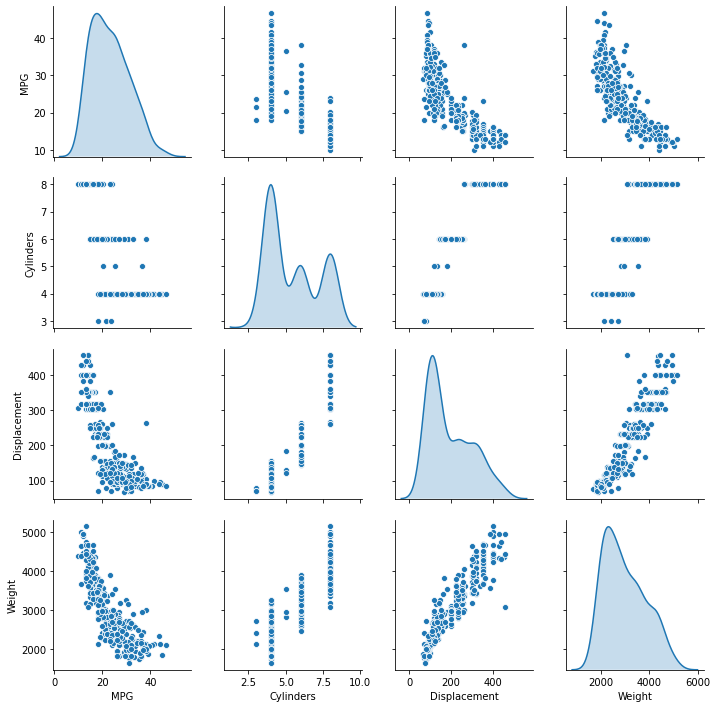

In [17]:
#Have a quick look at the joint distribution of a few pairs of columns from the training set.
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

### Prepare a Compute Target

#### One of the benefits of cloud compute is that it scales on-demand, enabling you to provision enough compute resources to process multiple runs of an experiment in parallel. You'll use an Azure Machine Learning compute cluster named aml-cluster (if it doesn't exist, it will be created).

In [22]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "aml-cluster"

try:
    # Get the cluster if it exists
    training_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If not, create it
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS2_V2', max_nodes=2)
    training_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

training_cluster.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Configure Automated Machine Learning

#### Now you're ready to configure the automated machine learning experiment. To do this, you'll need a run configuration that includes the required packages for the experiment environment, and a set of configuration settings that specifies how many combinations to try, which metric to use when evaluating models, and so on.

In [ ]:
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(name='Automated ML Experiment',
                             task='classification',
                             compute_target=training_cluster,
                             training_data = train_ds,
                             validation_data = test_ds,
                             label_column_name='Diabetic',
                             iterations=6,
                             primary_metric = 'AUC_weighted',
                             max_concurrent_iterations=2,
                             featurization='auto'
                             )

print("Ready for Auto ML run.")

### Separate the features from the target variable(mpg)

In [18]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the dataset

In [21]:

min_max_scaler = preprocessing.MinMaxScaler()


train_dataset[list(train_dataset.columns)] = min_max_scaler.fit_transform(train_dataset[list(train_dataset.columns)])
    

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
